In [1]:
import pandas as pd
from copy import deepcopy
import datetime
pd.options.display.max_rows = None
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, LassoCV, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.base import is_classifier, is_regressor
from sklearn.exceptions import ConvergenceWarning
import multiprocessing
from sklearn.utils import resample
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
import pickle
import itertools
from scipy.stats import norm
import openml
import matplotlib.pyplot as plt
import matplotlib
import time
from threadpoolctl import threadpool_limits
from econml.utilities import cross_product, WeightedModelWrapper

In [2]:
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
'''
Function that downloads and stores the data from the OpenML-CC18 benchmark tasks.
'''
def download_openmlcc18():
  openml.config.apikey = 'YOURKEY'
  openml.config.set_cache_directory('/root/openmlcache')
  benchmark_suite = openml.study.get_suite('OpenML-CC18') 
  for task_id in benchmark_suite.tasks:  
      task = openml.tasks.get_task(task_id)  
      print(task)
      features, targets = task.get_X_and_y()
      with open("/root/notebooks/OpenML-CC18/{}".format(task_id), "wb") as f:
        pickle.dump((features, targets), f)
        

In [4]:
'''
Function summarizing the downloaded OpenML-CC18 tasks.
'''
def summarize_openmlcc18():
  openmlcc18_summary = pd.DataFrame()

  openml.config.apikey = 'YOURKEY'
  openml.config.set_cache_directory('/root/openmlcache')
  benchmark_suite = openml.study.get_suite('OpenML-CC18') 

  print("Loading tasks...\r")
  for task_id, dataset_id in zip(benchmark_suite.tasks, benchmark_suite.data):  
      with open("/root/notebooks/OpenML-CC18/{}".format(task_id), "rb") as f:
        features, targets = pickle.load(f)
        entry = {"task_id" : task_id, "dataset_id": dataset_id, 
                 "samples" : features.shape[0], "contexts"  : features.shape[1], "arms" : len(np.unique(targets))}
        openmlcc18_summary = openmlcc18_summary.append(entry, ignore_index=True)
  openmlcc18_summary = openmlcc18_summary.astype(int)
  openmlcc18_summary = openmlcc18_summary.set_index('task_id')
  openmlcc18_summary = openmlcc18_summary.sort_values(by='samples', ascending=False)
  
  return openmlcc18_summary


In [5]:
'''
Class creating a bandit dataset out of an OpenML-CC18 task.
'''
class OpenMLCC18_World:
  def __init__(self, task_id, reward_variance=0):
    self.task_id = task_id
    with open("/root/notebooks/OpenML-CC18/{}".format(task_id), "rb") as f:
      self.contexts, self.arms = pickle.load(f)
    
    if np.sum(np.isnan(self.contexts)) > 0: 
      self.contexts = SimpleImputer().fit_transform(self.contexts)
    self.arm_count = len(np.unique(self.arms))
    self.feature_count = self.contexts.shape[1]
    self.observation_count = self.contexts.shape[0]

    shuffle = np.argsort(np.random.random(size=self.observation_count))
    self.contexts = self.contexts[shuffle]
    self.arms = self.arms[shuffle]
    self.context_to_optimal_arm_dict = dict(zip([tuple(c) for c in self.contexts], self.arms))
    self.reward_variance = reward_variance

    self.observation_index = 0

  def reset(self):
    self.observation_index = 0

  def optimal_arm(self, feature_vector):
    return self.context_to_optimal_arm_dict[tuple(feature_vector)]

  def regret(self, feature_vector, arm_id):
    return int(arm_id != self.context_to_optimal_arm_dict[tuple(feature_vector)])

  def reward(self, feature_vector, arm_id):
    reward_mean = int(arm_id == self.context_to_optimal_arm_dict[tuple(feature_vector)])
    return reward_mean + np.random.normal(loc=0, scale=np.sqrt(self.reward_variance))

  def reward_mean_per_arm(self, feature_vector):
    reward_means = np.zeros(self.arm_count)
    reward_means[self.context_to_optimal_arm_dict[tuple(feature_vector)]] = 1
    return reward_means

  def get_deterministic_batch_of_contexts(self, batch_size):
    start = self.observation_index
    end = self.observation_index + batch_size
    if end <= self.observation_count:
      self.observation_index = end
      return self.contexts[start:end, :], self.arms[start:end]
    else:
      end = end % self.observation_count
      self.observation_index = end
      return np.vstack([self.contexts[start:, :], self.contexts[:end, :]]), \
             np.vstack([self.arms[start:], self.arms[:end]])
   
  def get_new_batch_of_contexts(self, batch_size):
    contexts = resample(self.contexts, n_samples=batch_size)
    return contexts
    
  def get_fully_labeled_data(self, batch_size):
    contexts, labels = resample(self.contexts, self.arms, n_samples=batch_size)
    return contexts, labels
    

In [6]:
'''
Function wrapping prediction of expected outcome for both classifiers and regressors.
'''
def predict(model, X):
  # TODO(Update to work with classification pipelines.)
  if is_classifier(model):
    if len(model.classes_) == 1:
      return np.ones(len(X)) * model.classes_[0]
    else:
      return model.predict_proba(X)[:, 1]
  else:
    return model.predict(X)
  raise ValueError
  

In [7]:
'''
Class simulating logging policy. 
'''
class LoggingPolicy:
  def __init__(self, batch_count, batch_size, 
               outcome_model=None, logging_policy='uniform_random', epsilon_multiplier=1,
               verbose=False):
    self.batch_count = batch_count
    self.batch_size = batch_size
    self.outcome_model = outcome_model
    self.logging_policy = logging_policy
    self.epsilon_multiplier = epsilon_multiplier
    self.verbose = verbose
    
    self.debug_string = "world: {}\nbatch_count: {}\nbatch_size: {}\nbandit: {} {} epsilon_multiplier={}" \
          .format(world.__class__.__name__, self.batch_count, self.batch_size, 
                  self.logging_policy, self.outcome_model, self.epsilon_multiplier)
    
  def run(self):
    self.X = []
    self.A = []
    self.Y = []
    self.P = []
    self.regret = []
#     self.previous_P = []
    self.epsilon = []

    for batch_id in range(self.batch_count):
      if self.verbose:
        print("Progress: {}/{}...".format(batch_id + 1, self.batch_count), end='\r')

      X_test = world.get_new_batch_of_contexts(self.batch_size)

      outcome_models = []
      if self.logging_policy == 'uniform_random':
        epsilon = 1
        A_test = np.random.choice(range(world.arm_count), size=X_test.shape[0])
        P_test = np.ones(shape=(X_test.shape[0], world.arm_count)) * (1 / world.arm_count)

      elif self.logging_policy == 'contextual_epsilon_greedy':
        unique_arms, count_per_arm = np.unique(self.A, return_counts=True)
        if len(unique_arms) == world.arm_count and np.min(count_per_arm) >= 1:
          # Train the estimator and obtain predictions.
          Y_hat_test = np.zeros(shape=(X_test.shape[0], world.arm_count))
          for a in range(world.arm_count):
            indicator_a, = np.where(np.array(self.A) == a)
            Y_a = np.array(self.Y)[indicator_a]
            X_a = np.array(self.X)[indicator_a, :]
            model_a = deepcopy(self.outcome_model)
            # TODO(Update to work with classification pipelines.)
            if is_classifier(model_a):
              classes = np.unique(Y_a)
              if len(classes) == 1:
                model_a.classes_ = deepcopy(classes)
              else:
                with threadpool_limits(limits=1, user_api='blas'):
                  model_a.fit(X=X_a, y=Y_a)
            else:
              with threadpool_limits(limits=1, user_api='blas'):
                model_a.fit(X=X_a, y=Y_a)
            outcome_models.append(model_a)
            Y_hat_test[:, a] = predict(model_a, X_test)

          # Compute epsilon = (number of observations + 1)^(-1/3)
          epsilon = self.epsilon_multiplier * (batch_id * self.batch_size + 1)**(-1/3)

          # Choose arms.
          A_test_random = np.random.choice(range(world.arm_count), size=X_test.shape[0])
          A_test_best = np.argmax(Y_hat_test, axis=1)
          test_coin_flip = np.random.random(size=X_test.shape[0]) >= epsilon
          A_test = A_test_best * test_coin_flip + A_test_random * (1 - test_coin_flip)
          P_test = np.ones(shape=(X_test.shape[0], world.arm_count)) * (epsilon / world.arm_count) 
          for a in range(world.arm_count):
            P_test[:, a] = P_test[:, a] + (A_test_best == a).astype(int) * (1 - epsilon)
#           P_test = (1 - epsilon + epsilon / world.arm_count) * (A_test == A_test_best) \
#                  + (epsilon / world.arm_count) * (A_test != A_test_best)  

        else:
          # Not enough observations for contextual assignment; do uniform random instead.
          epsilon = 1
          A_test = np.random.choice(range(world.arm_count), size=X_test.shape[0])
          P_test = np.ones(shape=(X_test.shape[0], world.arm_count)) * (1 / world.arm_count)

      else:
        raise ValueError

      # Observe the outcomes.
      Y_test =  [world.reward(x, a) for x, a in zip(X_test, A_test)]

      # Store the observations.
      self.X += list(X_test)
      self.A += list(A_test)
      self.Y += list(Y_test)
      self.P += list(P_test)
      self.epsilon += [epsilon] * X_test.shape[0]

      # Store the self.regret.
      self.regret += [world.regret(x, a) for x, a in zip(X_test, A_test)]

#       # Log propensities for previous observations.
#       if len(outcome_models) == 0:
#         previous_P = np.ones(len(self.A)) * (1 / world.arm_count)
#       else:
#         Y_hat = np.zeros(shape=(len(self.X), world.arm_count))
#         for a, model_a in enumerate(outcome_models):
#           Y_hat[:, a] = predict(model_a, self.X)
#         A_best = np.argmax(Y_hat, axis=1)
#         previous_P = (np.array(self.A) == A_best) * (1 - epsilon + epsilon / world.arm_count) \
#                       + (np.array(self.A) != A_best) * (epsilon / world.arm_count)
#       self.previous_P.append(previous_P)

    self.X = np.array(self.X)
    self.A = np.array(self.A)
    self.Y = np.array(self.Y)
    self.P = np.array(self.P)
    self.regret = np.array(self.regret)
    self.epsilon = np.array(self.epsilon)
    

In [8]:
'''
Class implementing all ERM estimators when a joint model is trained across arms.
'''
class ERM:
  def __init__(self, bandit, outcome_model, training_size, evaluation_size, verbose=False):
    
    self.outcome_model = outcome_model
    self.training_size = training_size
    self.evaluation_size = evaluation_size
    
    # Retrieve training data from logging policy.
    self.X = bandit.X[0:training_size, :]
    self.Y = bandit.Y[0:training_size]
    self.A = bandit.A[0:training_size]
    self.g = np.array([bandit.P[i, bandit.A[i]] for i in range(training_size)])
    self.K = world.arm_count
    self.e = bandit.epsilon[0:self.training_size] / self.K
    
    # Draw evaluation contexts and get the ground truth mean reward per arm.
    self.X_eval = world.get_new_batch_of_contexts(self.evaluation_size)
    self.Q0 = np.array([world.reward_mean_per_arm(x) for x in self.X_eval])
    
    erm_list = dict([('unweighted', np.ones(len(self.X))),
                     ('ipw', 1/self.g), 
                     ('ipw_floor', 1/self.e), 
                     ('sqrt_ipw', 1/np.sqrt(self.g)), 
                     ('sqrt_ipw_floor', 1/np.sqrt(self.e)), 
                     ('mrdr', (1-self.g)/self.g**2), 
                     ('mrdr_floor', (1-self.e)/self.e**2)])
    
    self.erm_name_list = list(erm_list.keys())
    self.mse = []
    self.regret = []
    
    for (erm_name, w) in erm_list.items():
      self.w = w
      self.fit_erm(erm_name)
    
  def fit_erm(self, erm_name):
    Q = np.zeros((len(self.X_eval), self.K))

    
    if 'Linear' in str(self.outcome_model) or 'Ridge' in str(self.outcome_model) or 'Lasso' in str(self.outcome_model):
      one_hot_A = pd.get_dummies(self.A, drop_first=False).to_numpy()
      X_A_interacted = np.hstack(
        [PolynomialFeatures(degree=1, include_bias=True).fit_transform(self.X), 
         cross_product(PolynomialFeatures(degree=1, include_bias=True).fit_transform(self.X),
                       one_hot_A)])
      
      with threadpool_limits(limits=1, user_api='blas'):
        model = WeightedModelWrapper(deepcopy(self.outcome_model))
        model.fit(X=X_A_interacted, y=self.Y, sample_weight=self.w)
        for a in range(self.K):
          A_eval = np.zeros(self.K)
          A_eval[a] = 1
          A_eval = np.repeat(A_eval.reshape(1, -1), len(self.X_eval), axis=0)
          X_eval_A_eval_interacted = np.hstack(
            [PolynomialFeatures(degree=1, include_bias=True).fit_transform(self.X_eval), 
             cross_product(PolynomialFeatures(degree=1, include_bias=True).fit_transform(self.X_eval),
                           A_eval)])
          Q[:, a] = model.predict(X_eval_A_eval_interacted)
                     
    elif 'Tree' in str(self.outcome_model):
      one_hot_A = pd.get_dummies(self.A, drop_first=False).to_numpy()
      X_A = np.hstack((self.X, one_hot_A))
      with threadpool_limits(limits=1, user_api='blas'):
        model = deepcopy(self.outcome_model)
        model.fit(X=X_A, y=self.Y, sample_weight=self.w)
        for a in range(self.K):
          A_eval = np.zeros(self.K)
          A_eval[a] = 1
          A_eval = np.repeat(A_eval.reshape(1, -1), len(self.X_eval), axis=0)
          X_eval_A_eval = np.hstack((self.X_eval, A_eval))
          Q[:, a] = model.predict(X_eval_A_eval)
    
    else:
      raise ValueError
    
    mse = np.mean((Q - self.Q0)**2)
    self.mse.append(mse)
    
    max_reward = np.max(self.Q0, axis=1)
    policy = np.argmax(Q, axis=1)
    policy_reward = np.array([self.Q0[i, policy[i]] for i in range(len(self.X_eval))])
    regret = np.mean(max_reward - policy_reward)
    self.regret.append(regret)

In [9]:
'''
Class running many LoggingPolicy instances in parallel.
'''
class BanditSimulator:
  def __init__(self, bandit, simulation_count, seed=1704, verbose=False):
    
    self.bandit = bandit
    self.simulation_count = simulation_count
    self.seed = seed
    
    self.manager = multiprocessing.Manager()
    self.manager_bandit_list = self.manager.list()
    self.bandit_list = None
    self.regret_list = None
    
    self.verbose = verbose
    
    self.debug_string = self.bandit.debug_string \
                      + "\nsimulation_count: {}\nseed: {}".format(self.simulation_count, self.seed)
    
  def simulate(self):
    if self.seed is not None:
      np.random.seed(self.seed)
      
    t0 = time.time()
    processes = []
    for s in range(self.simulation_count):
      p = multiprocessing.Process(target=self.single_simulation, args=(s,))
      processes.append(p)
    [p.start() for p in processes]
    [p.join() for p in processes]
    [p.terminate() for p in processes]
    t1 = time.time()
    print("BanditSimulator.simulate() DONE ({}) ".format(t1-t0))
   
  def single_simulation(self, s):
    t0 = time.time()
    np.random.seed((s+1) * 1704)
    bandit_s = LoggingPolicy(batch_count=self.bandit.batch_count, batch_size=self.bandit.batch_size, 
                             logging_policy=self.bandit.logging_policy, 
                             outcome_model=deepcopy(self.bandit.outcome_model), 
                             epsilon_multiplier=self.bandit.epsilon_multiplier)
    bandit_s.run()
    self.manager_bandit_list.append(bandit_s)
    t1 = time.time()
    if self.verbose:
      print("\tBanditSimulator.single_simulation({}) DONE ({}) ".format(s, t1-t0))
    
  def aggregate(self):
    t0 = time.time()
    self.bandit_list = list(self.manager_bandit_list)
    self.manager.shutdown()
    self.regret_list = []
    for bandit in self.bandit_list:
      self.regret_list.append(bandit.regret)
    t1 = time.time()
    print("BanditSimulator.aggregate() DONE ({}) ".format(t1-t0))
    

In [10]:
'''
Class running many ERM instances in parallel with input 
a list of bandit data collected by different LoggingPolicy instances. 
'''
class ERMSimulator:
  def __init__(self,
               bandit_simulator, 
               outcome_model, evaluation_size,
               training_sample_count,
               verbose=False,
               seed=1704):
    
    self.bandit_simulator = bandit_simulator
    self.outcome_model = outcome_model
    self.evaluation_size = evaluation_size
    
    self.training_sample_count = training_sample_count
    self.training_sample_size = (self.bandit_simulator.bandit.batch_count
                                 * self.bandit_simulator.bandit.batch_size) / self.training_sample_count
   
    self.seed = seed
    self.verbose = verbose
    
    self.simulation_count = self.bandit_simulator.simulation_count
    
    self.manager = multiprocessing.Manager()
    self.manager_mse_list = self.manager.list([[] for s in range(self.simulation_count)])
    self.manager_regret_list = self.manager.list([[] for s in range(self.simulation_count)])
    self.manager_erm_name_list = self.manager.list()
    
  def simulate(self):
    if self.seed is not None:
      np.random.seed(self.seed)
      
    t0 = time.time()
    processes = []
    for s in range(self.simulation_count):
      p = multiprocessing.Process(target=self.single_simulation, args=(s,))
      processes.append(p)
    [p.start() for p in processes]
    [p.join() for p in processes]
    [p.terminate() for p in processes]
    t1 = time.time()
    print("\nERMSimulator.simulate() DONE ({}) ".format(t1-t0))
      
   
  def single_simulation(self, s):
    t0 = time.time()
    
    np.random.seed((s+1) * 1704)
    
    bandit = self.bandit_simulator.bandit_list[s]
    
    mse_per_training_size = []
    regret_per_training_size = []
    for t in range(self.training_sample_count): 
      if s==0:
        print(t, end='')
      erm = ERM(bandit=bandit, outcome_model=self.outcome_model, 
                training_size=int((t+1) * self.training_sample_size), 
                evaluation_size=self.evaluation_size)
      mse_per_training_size.append(erm.mse)
      regret_per_training_size.append(erm.regret)
      
    self.manager_mse_list[s] = mse_per_training_size
    self.manager_regret_list[s] = regret_per_training_size
    if s == 0:
      self.manager_erm_name_list.append(erm.erm_name_list)
    
    t1 = time.time()
    
    if self.verbose:
      print("\tERMSimulator.single_simulation({}) DONE ({}) ".format(s, t1-t0))
    
  def aggregate(self):
    t0 = time.time()
    
    self.mse_list = [self.manager_mse_list[s] for s in range(self.simulation_count)]
    self.regret_list = [self.manager_regret_list[s] for s in range(self.simulation_count)]
    self.erm_name_list = self.manager_erm_name_list[0]
    self.manager.shutdown()
    
    t1 = time.time()
    print("ERMSimulator.aggregate() DONE ({}) ".format(t1-t0))
    

In [11]:
def print_relative_mse_regret(sim, name):
  sample_sizes = np.arange(sim.training_sample_size, (sim.training_sample_count + 1) * sim.training_sample_size,
                           sim.training_sample_size)
  erm_names = sim.erm_name_list

  regret_array = np.array(sim.regret_list)
  mse_array = np.array(sim.mse_list)

  n0 = sim.erm_name_list.index('unweighted')
  unweighted_regret = np.zeros_like(regret_array)
  for n in range(regret_array.shape[2]):
    unweighted_regret[:, :, n] = deepcopy(regret_array[:, :, n0])
  unweighted_mse = np.zeros_like(mse_array)
  for n in range(mse_array.shape[2]):
    unweighted_mse[:, :, n] = deepcopy(mse_array[:, :, n0])

  all_regrets_mean = np.mean(regret_array / unweighted_regret, axis=0)
  all_regrets_var = np.var(regret_array / unweighted_regret, axis=0) / sim.simulation_count
  all_mses_mean = np.mean(mse_array / unweighted_mse, axis=0)
  all_mses_var = np.var(mse_array / unweighted_mse, axis=0) / sim.simulation_count

  for n, erm_name in enumerate(erm_names):
    plt.errorbar(sample_sizes, all_regrets_mean[:, n], yerr=np.sqrt(all_regrets_var[:, n]), label=erm_name)
  plt.title('{} Regret'.format(name))
  plt.legend()
  plt.show()

  for n, erm_name in enumerate(erm_names):
    plt.errorbar(sample_sizes, all_mses_mean[:, n], yerr=np.sqrt(all_mses_var[:, n]), label=erm_name)
  plt.title('{} MSE'.format(name))
  plt.legend()
  plt.show()

In [24]:
def create_iswerm_to_othererm_scatterplot(data, training_sample_index, metric_name, setup, z=1):
  setup_metric_data = np.array(list(data['{}_{}_list'.format(setup, metric_name.lower())]))
  setup = setup.upper()
  mean = np.mean(setup_metric_data, axis=1)
  stderr = np.sqrt(np.var(setup_metric_data, axis=1) / setup_metric_data.shape[1])
  
  pretty_names = ['Unweighted ERM', 'ISWERM', 'ISFloorWERM', 'SqrtISWERM', 'SqrtISFloorWERM', 'MRDRWERM', 'MRDRFloorWERM']
  t = training_sample_index
  max_metric_value = np.quantile(mean[:, t, :] + stderr[:, t, :], q=0.95)
  
  size = 2.5
  ncols = mean.shape[2]-1
  fontsize = 16
  figure, axes = plt.subplots(nrows=1, ncols=ncols, figsize=((ncols + 2) * size, size))
  figure.subplots_adjust(top = 0.9, bottom=0.01, hspace=0.25, wspace=0.25)
  i1 = 1
  for i2 in range(mean.shape[2]):
    if i2 == i1:
      continue
    colors = []
    for d in range(mean.shape[0]):
      y = mean[d, t, i1]
      x = mean[d, t, i2]
      yerr = stderr[d, t, i1]
      xerr = stderr[d, t, i2]
      if np.abs(x - y) <= z*(xerr + yerr):
        colors.append([0,0,0])
      elif x > y:
        colors.append([0,0,1])
      elif x < y:
        colors.append([1,0,0])
      else:
        raise ValueError
    ax = axes[i2] if i2 < 1 else axes[i2-1]
    ax.scatter(y=mean[:, t, i1], x=mean[:, t, i2], c=colors, zorder=3, alpha=0.6)
    ax.errorbar(y=mean[:, t, i1], x=mean[:, t, i2], yerr=z*stderr[:, t, i1], xerr=z*stderr[:, t, i2], 
                c='black', zorder=0, fmt='none')
    ax.tick_params(axis='both', which='major', labelsize=fontsize-4)
    if i2 == 0:
      ax.set_ylabel(pretty_names[i1], fontsize=fontsize)
    ax.set_title(pretty_names[i2], fontsize=fontsize)
    ax.axline(xy1=(0, 0), xy2=(1.1*max_metric_value, 1.1*max_metric_value), 
              linestyle='-', color='black', alpha=0.3) 
    ax.set_xlim([0, 1.2*max_metric_value])
    ax.set_ylim([0, 1.2*max_metric_value])
  plt.show()

In [ ]:
# Setup.
print_intermediate_plots = False

simulation_count = 64
reward_variance = 1
epsilon_multiplier = 1
batch_count = 1000
batch_size = 100
bandit_model = 'linear' # or 'tree'

training_sample_count = 10
evaluation_size=1000

task_min_samples = 0
task_max_contexts = 60

setup_string = 'tms{}_tmc{}_tsc{}_es{}_s{}_rv{}_em{}_bc{}_bs{}_{}'.format(
    task_min_samples, task_max_contexts, training_sample_count, evaluation_size, 
    simulation_count, reward_variance, epsilon_multiplier, batch_count, batch_size, bandit_model)

# Select the tasks.
all_tasks_summary_df = pd.read_pickle('all_tasks_summary_df')
selected_tasks_summary_df = all_tasks_summary_df[
    (all_tasks_summary_df['samples'] >= task_min_samples) 
  & (all_tasks_summary_df['contexts'] <= task_max_contexts)]
selected_tasks_summary_df.to_pickle('{}_task_summary_df'.format(setup_string))

# Run simulation.
all_tasks_df_data =  pd.DataFrame()
print("Selected {} tasks.\n".format(len(selected_tasks_summary_df.index)))
world = None
for task_id in selected_tasks_summary_df.index:
  t0 = time.time()
  
  print('\n======================================== task_id: {} ========================================'
        .format(task_id))
  print(selected_tasks_summary_df.loc[task_id][['arms', 'contexts', 'samples']])
  print()
  
  # Collect data with some contextual policy.
  world=OpenMLCC18_World(task_id=task_id, reward_variance=reward_variance) 

  # Train bandits.
  bandit_simulator = BanditSimulator(
    bandit=LoggingPolicy(batch_count=batch_count, batch_size=batch_size, 
                         logging_policy='contextual_epsilon_greedy', 
                         outcome_model=LinearRegression() if bandit_model=='linear' else DecisionTreeRegressor(), 
                         epsilon_multiplier=epsilon_multiplier), 
                         simulation_count=simulation_count, seed=1704)

  bandit_simulator.simulate()
  bandit_simulator.aggregate()

  # Print bandit regret.
  if print_intermediate_plots:
    horizon = len(bandit_simulator.bandit_list[0].A)
    uniform_regret_list = []
    for s in range(4):
      uniform_X = world.get_new_batch_of_contexts(horizon)
      uniform_A = np.random.choice(range(world.arm_count), size=horizon)
      uniform_regret_list.append([world.regret(x, a) for x, a in zip(uniform_X, uniform_A)])

    uniform_regrets = np.mean(np.array(uniform_regret_list), axis=0)
    plt.plot(np.cumsum(uniform_regrets), linewidth=2, color='black', linestyle='--', label='Uniform Random')  
    regrets = [np.mean(bandit_simulator.regret_list, axis=0)]
    for r in zip(regrets):
      plt.plot(np.cumsum(r), linewidth=2)
    plt.title("Multi-Class Classification Environment {} (Reward Variance {})\nTree ".format(task_id, reward_variance) 
              + r"$\epsilon$" + "-Greedy {} Bandit: ".format(bandit_simulator.bandit.outcome_model) 
              + r"$\epsilon_0 = {}$".format(epsilon_multiplier))
    plt.ylabel("Cumulative Regret")
    plt.xlabel("t")
    plt.show()

  # Fit ERM under different outcome model setups.
  all_setups_dict = dict()

  setups = {
            'RidgeCV' : RidgeCV(cv=4, fit_intercept=False),
            'LassoCV' : LassoCV(cv=4, fit_intercept=False),
            'Tree' : DecisionTreeRegressor()
           }

  for i, (name, outcome_model) in enumerate(setups.items()):
    print("-------------------------- outcome setup: {} --------------------------".format(name))
    simulator = ERMSimulator(bandit_simulator=bandit_simulator,
                               outcome_model=outcome_model,
                               training_sample_count=training_sample_count,
                               evaluation_size=evaluation_size)

    simulator.simulate()
    simulator.aggregate()

    this_setup_dict = {"{}_mse_list".format(name) : simulator.mse_list,
                       "{}_regret_list".format(name) : simulator.regret_list
                      }
    all_setups_dict = dict(list(all_setups_dict.items()) + list(this_setup_dict.items()))
    
    if print_intermediate_plots:
      print_relative_mse_regret(simulator, name)


  additional_columns = {'erm_name_list': simulator.erm_name_list,
                        'setup_name_list': list(setups.keys())}
  all_setups_dict = dict(list(all_setups_dict.items()) + list(additional_columns.items()))

  # Store results.
  this_task_df_data = pd.DataFrame()
  this_task_df_data = this_task_df_data.append(all_setups_dict, ignore_index=True)
  this_task_df_data['task_id'] = task_id
  all_tasks_df_data = pd.concat([all_tasks_df_data, this_task_df_data], ignore_index=True)
  all_tasks_df_data.to_pickle('{}_all_tasks_df_data'.format(setup_string))
  
  t1 = time.time()
  print('task_id: {} DONE ({})'.format(task_id, t1-t0))
  

In [27]:
data = pd.read_pickle('{}_all_tasks_df_data'.format(setup_string))

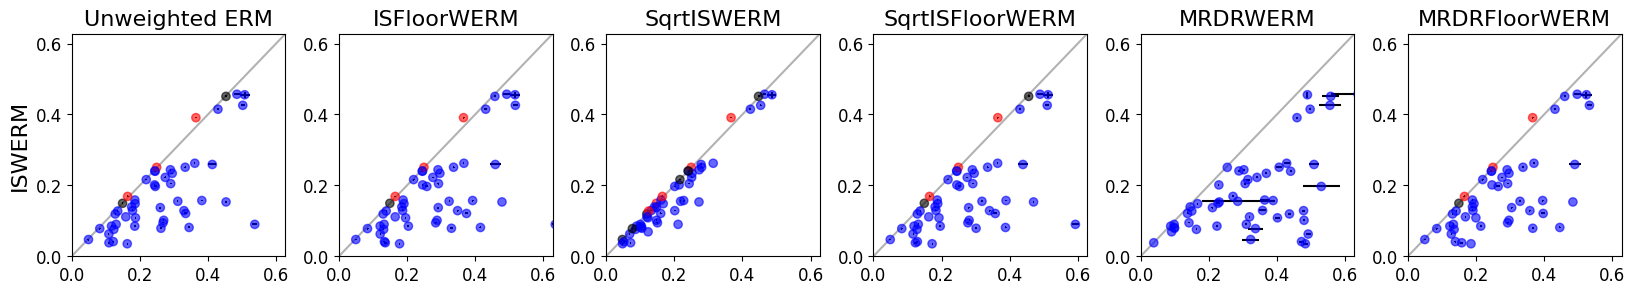

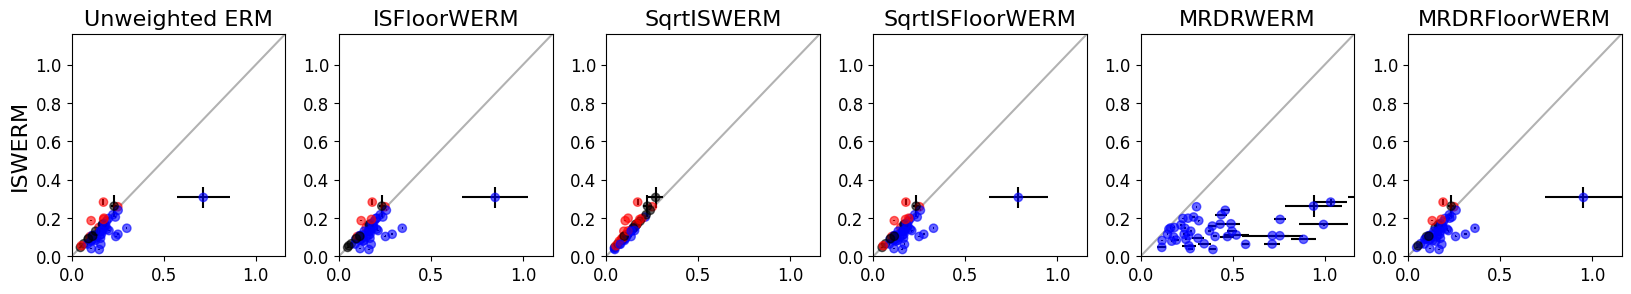

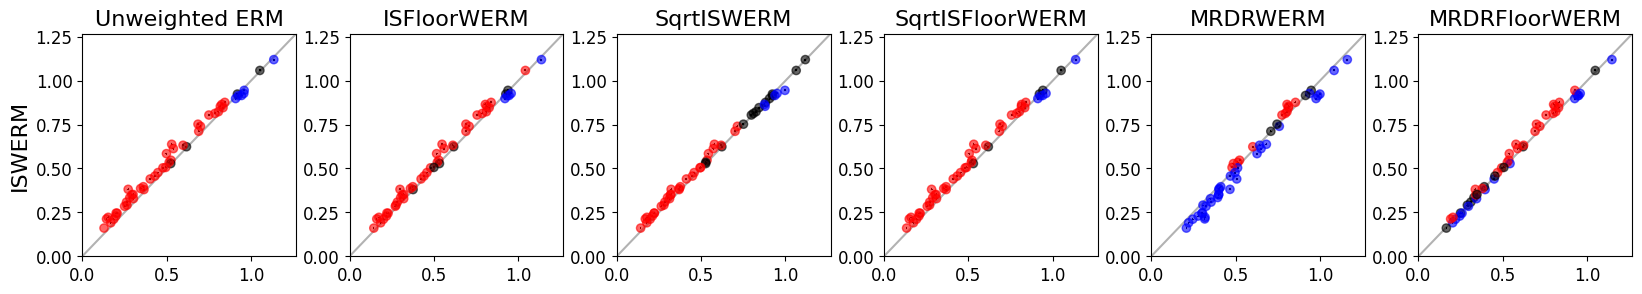

In [28]:
create_iswerm_to_othererm_scatterplot(data=data, training_sample_index=9, metric_name='MSE', setup='LassoCV')
create_iswerm_to_othererm_scatterplot(data=data, training_sample_index=9, metric_name='MSE', setup='RidgeCV')
create_iswerm_to_othererm_scatterplot(data=data, training_sample_index=9, metric_name='MSE', setup='TreeJoint')